In [2]:
import seaborn as sns
import json
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt 
import re
import pathlib 

from data import get_source_triggers, split_by_intent

colors = ['#7f3b08','#b35806','#e08214','#fdb863','#8e0152','#d73027','#4575b4','#b2abd2','#8073ac','#542788','#2d004b']
# intents_and_functions = ['play_radio', "FindManager", 'email_query', "Tomorrow", 'email_querycontact', "PlaceHasFeature", 'general_quirky', "DoNotConfirm", 'traffic', "FenceAttendee", "total"]
intents_and_functions = [50, "FindManager", 15, "Tomorrow", 16, "PlaceHasFeature", 27, "DoNotConfirm", 66, "FenceAttendee", "total"]
color_mapping = {k:v for k,v in zip(intents_and_functions, colors)}


In [12]:
def get_accuracy_intent(pred_file, intent, triggers):
    try:
        with open(pred_file) as f1:
            pred_data = json.load(f1)
    except FileNotFoundError:
        print(f"file {pred_file} doesn't exist")
        return np.nan, [], [], 0
    #with open(data_file) as f1:
    
    total = 0
    correct_examples = []
    incorrect_examples = []

    for example in pred_data:
        true_label = example['true']
        source = re.split("\s+", example['input']) 
        has_trigger = any([t in source for t in triggers])
        if true_label != intent and has_trigger: 
            max_pred = np.argmax(example['pred'])
            total += 1
            if max_pred == true_label: 
                correct_examples.append(example)
            else:
                incorrect_examples.append(example)
        else:
            continue

    try:
        acc = len(correct_examples)/total 
    except ZeroDivisionError:
        return np.nan, [], [], 0
    # print(f"{pred_file} has total {total}")
    return acc, correct_examples, incorrect_examples, total


def get_accuracy_calflow(pred_tgt, true_src, true_tgt, fxn, triggers):
    print(len(true_src), len(true_tgt), len(pred_tgt))
    assert(len(true_src) == len(true_tgt) == len(pred_tgt))

    total = 0
    correct_examples = []
    incorrect_examples = []

    for pred, src, tgt in zip(pred_tgt, true_src, true_tgt):
        pred, src, tgt = pred.strip(), src.strip(), tgt.strip() 
        is_correct = pred == tgt 
        tgt_tok = re.split("\s+", tgt)
        src_tok = re.split("\s+", src)
        has_fxn = fxn in tgt_tok
        has_trigger = any([t in src_tok for t in triggers])
        if not has_fxn and has_trigger:
            total += 1
            if is_correct:
                correct_examples.append((pred, src, tgt))
            else:
                incorrect_examples.append((pred, src, tgt))

    try:
        acc = len(correct_examples)/total 
    except ZeroDivisionError:
        return np.nan, [], [], 0
    return acc, correct_examples, incorrect_examples, total  

In [4]:

def collect_intent(paths_and_types, splits = [750, 1500, 3000, 7500, 15000, 18000], fxn_splits = [15, 30, 75], intents=[50, 66, 16, 27, 15], seeds=[12, 31, 64], 
                    train_data_path = "/home/estengel/incremental-function-learning/intent/data/nlu_eval_data/"):

    df = pd.DataFrame(columns=["fxn", "type", "train", "examples", "seed", "acc", "total"], dtype=object) 

    for path, type_name in paths_and_types:
        path = pathlib.Path(path)
        for intent in intents:
            for seed in seeds:
                for split in splits:
                    for fxn_split in fxn_splits:
                        pred_path = path.joinpath(str(intent), f"{seed}_seed", f"{split}_{fxn_split}", "test_predictions.json")
                        train_data, __, __ = split_by_intent(train_data_path, intent, split, fxn_split)
                        triggers = get_source_triggers(train_data, intent)
                        acc, correct, incorrect, total = get_accuracy_intent(pred_path, intent, triggers)
                        df = df.append({"fxn": intent, "train": str(split), "examples": fxn_split, "type": type_name, "seed": seed, "acc": acc, "total": total}, ignore_index=True)
    return df 


df = collect_intent([("/brtx/603-nvme1/estengel/intent_fixed_test/intent/", "baseline"), 
                     ("/brtx/603-nvme1/estengel/intent_fixed_test/intent_no_source/", "no_source")])



There are 57 instances of 50 in dev and 116 in test
There are 57 instances of 50 in dev and 116 in test
There are 57 instances of 50 in dev and 116 in test
There are 57 instances of 50 in dev and 116 in test
There are 57 instances of 50 in dev and 116 in test
There are 57 instances of 50 in dev and 116 in test
There are 57 instances of 50 in dev and 116 in test
There are 57 instances of 50 in dev and 116 in test
There are 57 instances of 50 in dev and 116 in test
There are 57 instances of 50 in dev and 116 in test
There are 57 instances of 50 in dev and 116 in test
There are 57 instances of 50 in dev and 116 in test
There are 57 instances of 50 in dev and 116 in test
There are 57 instances of 50 in dev and 116 in test
There are 57 instances of 50 in dev and 116 in test
There are 57 instances of 50 in dev and 116 in test
There are 57 instances of 50 in dev and 116 in test
There are 57 instances of 50 in dev and 116 in test
There are 57 instances of 50 in dev and 116 in test
There are 57

In [13]:

trigger_lookup = {"FindManager": ["boss", "manager", "supervisor"],
                  "Tomorrow": ["tomorrow"],
                  "DoNotConfirm": ["cancel", "n't", "no"],  
                  "PlaceHasFeature": ["takeout","casual","waiter"],
                  "FenceAttendee": ["mom", "meet"]}

def collect_calflow(paths_and_types, splits = [5000, 10000, 20000, 50000, 100000, "max"], fxn_splits = [100], fxns=["FindManager", "Tomorrow", "DoNotConfirm", "FenceAttendee", "PlaceHasFeature"], seeds=[12, 31, 64], 
                    train_data_path = "/brtx/601-nvme1/estengel/resources/data/smcalflow.agent.data/"):

    df = pd.DataFrame(columns=["fxn", "type", "train", "examples", "seed", "acc", "total"], dtype=object) 

    train_data_path = pathlib.Path(train_data_path)    

    true_tgt_path = train_data_path.joinpath("test_valid.tgt")
    true_src_path = train_data_path.joinpath("test_valid.src")
    with open(true_src_path) as tsf, open(true_tgt_path) as ttf:
        true_src = tsf.readlines()
        true_tgt = ttf.readlines()

    for path, type_name in paths_and_types:
        path = pathlib.Path(path)
        for fxn in fxns:
            for seed in seeds:
                for split in splits:
                    for fxn_split in fxn_splits:
                        pred_tgt_path = path.joinpath(f"{fxn}_{split}_{fxn_split}_{seed}_seed_test_valid.tgt") 
                        if not pred_tgt_path.exists():
                            print(f"Missing {pred_tgt_path}")
                            continue
                        with open(pred_tgt_path) as ptf:
                            pred_tgt = ptf.readlines()
                        triggers = trigger_lookup[fxn]
                        acc, correct, incorrect, total = get_accuracy_calflow(pred_tgt, true_src, true_tgt, fxn, triggers)

                        df = df.append({"fxn": intent, "train": str(split), "examples": fxn_split, "type": type_name, "seed": seed, "acc": acc, "total": total}, ignore_index=True)
    return df 


collect_calflow([("/home/estengel/papers/incremental_function_learning/results/no_source", "no_source")], fxns=["FenceAttendee"])



6681 6681 6614


AssertionError: 

<AxesSubplot:xlabel='train', ylabel='acc'>

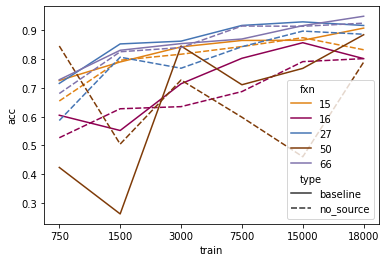

In [32]:
sub_df = df[df['examples']==75]
# sub_df = sub_df[sub_df['fxn'] == 66]
sns.lineplot(data=sub_df, x="train", y='acc', hue='fxn', style="type", palette=color_mapping, err_style=None)

In [1]:

fig, ax = plt.subplot(figsize=(4,4))

sns.barplot(data=sub_df, x="type", y = "acc", hue="fxn", palette=color_mapping)
sns.despine()

plt.savefig("/home/estengel/papers/incremental_function_learning/figures/for_paper/difficult_examples.pdf")

NameError: name 'plt' is not defined

In [62]:

from source_lookup import get_probs, tokenize

intent = 27
split=750
fxn_split=75
train_path = "/home/estengel/incremental-function-learning/intent/data/nlu_eval_data/" 
#with open("/home/estengel/incremental-function-learning/intent/data/nlu_eval_data/train.json") as f1:
#    train_data = json.load(f1)

train_data, __, __ = split_by_intent(train_path, intent, split, fxn_split)
train_data = tokenize(train_data)

prob_intent_given_word, prob_word_given_intent = get_probs(train_data, exclude_function=True)

triggers = get_source_triggers(train_data, intent)
print(triggers)

There are 101 instances of 27 in dev and 224 in test
['today', 'how', 'day']


In [65]:
prob_intent_given_word['day'][intent]


0.5714285714285714